# 📘 VAR–VECM Based Cointegration and Portfolio Pairs Trading

## 🧠 Introduction

In quantitative finance, **pairs trading** relies on the idea that certain asset pairs move together over time, maintaining a *long-run equilibrium relationship*.  
When this equilibrium temporarily diverges, traders can exploit the mean-reverting nature of their *spread* by buying the underpriced asset and selling the overpriced one.

To model and detect these long-run equilibria, we use **Vector Autoregression (VAR)** and **Vector Error Correction Models (VECM)** — multivariate time-series models that capture both **short-term dynamics** and **long-term cointegration**.

- **VAR (Vector Autoregression)** models the joint evolution of multiple time series assuming *stationarity* — suitable for assets whose returns (differences) are stable over time.
- **VECM (Vector Error Correction Model)** extends VAR to handle *non-stationary but cointegrated* series — assets that individually drift but maintain a stable long-run relationship.

Thus:
- If the assets are *not cointegrated*, we use a **VAR on differenced data**.
- If cointegration exists, we fit a **VECM**, which explicitly models both the equilibrium correction (long-run mean reversion) and short-run interactions.

---

## ⚖️ VAR–VECM vs. Engle–Granger / OLS

| Aspect | VAR / VECM Approach | Engle–Granger / OLS Approach |
|:--|:--|:--|
| **Model Scope** | Multivariate (handles more than two series simultaneously) | Bivariate (one dependent, one independent) |
| **Cointegration Test** | Johansen Test (trace/eigenvalue tests; multiple cointegrating vectors possible) | Engle–Granger test (ADF on OLS residuals; only one possible cointegrating relation) |
| **Estimation** | System-based MLE estimation considering all equations jointly | Single-equation OLS regression |
| **Dynamic Interactions** | Captures bidirectional causality between variables | Only captures unidirectional dependence (Y on X) |
| **Forecasting** | Naturally extends to multivariate forecasting (joint dynamics) | Not directly suited for multi-step forecasts |
| **Computational Complexity** | Higher (matrix algebra, system estimation) | Lower (single regression) |
| **Interpretability** | Richer, but parameters harder to interpret | Simple, intuitive regression coefficients |

In short:
- **Engle–Granger / OLS** is simpler but limited to one cointegrating vector.
- **VECM / VAR** is more powerful, allowing for *system-wide equilibrium modeling*, and is statistically more robust when working with several assets.

---

## 💡 Advantages of VAR–VECM Based Trading

1. **Captures both short-term and long-term relationships**  
   – VECM distinguishes between transient noise and genuine equilibrium deviations.

2. **Multivariate consistency**  
   – Treats all variables symmetrically, avoiding arbitrary “dependent vs. independent” choices.

3. **More robust to endogeneity**  
   – Joint system estimation avoids bias from simultaneous interactions.

4. **Forecasting capability**  
   – VAR/VECM frameworks can directly forecast future price movements and spreads.

5. **Automatic lag selection**  
   – Information criteria (AIC, BIC) guide model complexity objectively.

---

## ⚠️ Limitations and Practical Challenges

1. **Data requirements**  
   – Requires sufficiently long, high-quality historical data for stable estimation.

2. **Model sensitivity**  
   – Results (especially cointegration rank) depend on lag length, deterministic terms, and data frequency.

3. **Non-stationary volatility and regime shifts**  
   – Structural breaks can invalidate long-run equilibria; frequent recalibration is needed.

4. **Complexity and computation**  
   – Multivariate estimation is resource-intensive for large portfolios.

5. **Real-world execution friction**  
   – Transaction costs, slippage, and shorting constraints can erode theoretical profits.

---

# 🧩 Function Overview — Cointegration Analysis and Forecasting Workflow

This section describes the logical flow and purpose of the main functions used in the VAR/VECM cointegration framework and forecasting pipeline.  
Each function plays a specific role in transforming raw market data into model-based cointegration insights and forecasts.

---

## 🔹 `def cointF():`

**Purpose:**  
Performs **cointegration analysis and forecasting** for a *specific set of tickers* (usually two or more).  
It’s designed as the *core analytical engine* that combines data collection, model selection, and forecast generation.

**Key Steps:**
1. **Data Collection:**  
   - Downloads historical adjusted close prices from Yahoo Finance.  
   - Cleans and aligns time series for all input tickers.

2. **Data Transformation:**  
   - Converts prices into logarithmic scale (log-prices), ensuring stability and stationarity in differences.

3. **Lag Selection:**  
   - Runs a **VAR lag order selection** using AIC/BIC criteria on the differenced log prices to identify optimal model complexity.

4. **Cointegration Testing:**  
   - Applies the **Johansen test** to detect the number of cointegrating relationships (`rank r`) among the time series.

5. **Model Fitting:**  
   - If cointegration exists (`r ≥ 1`): fits a **VECM** model capturing both long-run equilibrium and short-run dynamics.  
   - Otherwise: falls back to a **VAR model** on differenced (stationary) data.

6. **Forecasting:**  
   - Uses the fitted model (VECM or VAR) to forecast **future joint movements** of all tickers for the next *n* days (`forecast_horizon`).

7. **Output:**
   - Prints model diagnostics, lag order selection, and cointegration results.
   - Returns a structured forecast DataFrame (log and level prices) ready for backtesting or visualization.

In summary, `cointF()` is the **core driver for pair-level cointegration testing and joint price forecasting**.

---

In [1]:
# pairs_var_vecm_icici_hdfc.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm

# multi_ticker_var_vecm_full.py
from statsmodels.tsa.stattools import coint  # Engle-Granger pairwise

# pure_vecm_pairwise_forecast.py
import itertools
import os

Downloaded 741 rows from 2022-10-18 to 2025-10-16

Lag order selection criteria (on differences):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.05     -16.04*   1.072e-07     -16.04*
1       -16.04      -16.00   1.080e-07      -16.03
2      -16.05*      -15.99  1.069e-07*      -16.03
3       -16.05      -15.96   1.071e-07      -16.02
4       -16.05      -15.93   1.074e-07      -16.00
5       -16.04      -15.90   1.084e-07      -15.98
6       -16.03      -15.87   1.092e-07      -15.97
7       -16.02      -15.83   1.101e-07      -15.95
8       -16.02      -15.81   1.101e-07      -15.94
9       -16.01      -15.77   1.111e-07      -15.92
10      -16.00      -15.74   1.122e-07      -15.90
11      -16.00      -15.71   1.129e-07      -15.89
12      -15.99      -15.67   1.136e-07      -15.87
--------------------------------------------------

Selected lag by AIC: 2
Selected la

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


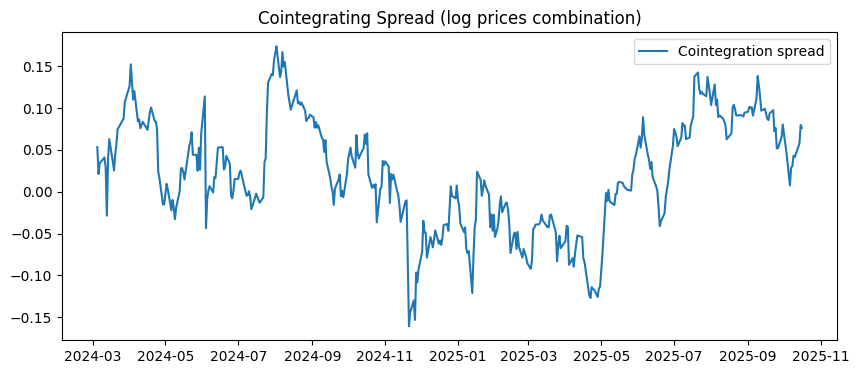


Forecast (next 10 business days) — log-price forecast (first rows):
            ADANIPORTS_log  AXISBANK_log
2025-10-17        7.294747      7.085402
2025-10-20        7.297788      7.087829
2025-10-21        7.297036      7.087504
2025-10-22        7.296907      7.087708
2025-10-23        7.296411      7.087602

Forecast level prices (exp of log-forecast):
            ADANIPORTS_log  AXISBANK_log
2025-10-17     1472.544242   1194.403155
2025-10-20     1477.029623   1197.305722
2025-10-21     1475.918188   1196.916889
2025-10-22     1475.728638   1197.161273
2025-10-23     1474.996326   1197.034139

--- Cointegration decision ---
Cointegration detected (rank r=1). VECM fitted.

Suggested pairs-trading rules (example):
1) If cointegrated: form spread S_t = beta' * log_prices_t.
2) z_t = (S_t - rolling_mean_60) / rolling_std_60.
3) Entry: go LONG spread when z < -2, SHORT spread when z > +2.
4) Exit: close when z reverts to 0 (or when z crosses +/-0.5), add stop-loss if z moves beyond +

In [6]:
# ---------- USER PARAMETERS ----------
# Tickers and period — change if you want different tickers / exchange
tickers = ["ADANIPORTS.NS", "AXISBANK.NS",]  # Yahoo Finance NSE tickers
start_date = (datetime.today() - timedelta(days=3*365)).strftime("%Y-%m-%d")  # 3 years
end_date = datetime.today().strftime("%Y-%m-%d")
freq = "1d"   # daily
maxlags_to_check = 12  # for lag selection
forecast_horizon = 10   # days to forecast
# -------------------------------------

def cointF():
  # 1) Download data
  df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, interval=freq, progress=False)["Adj Close"]
  df = df.dropna()
  df.columns = ["ADANIPORTS", "AXISBANK"]
  print(f"Downloaded {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")

  # 2) Use log prices (common practice)
  logp = np.log(df).rename(columns=lambda c: c + "_log")

  # 3) Prepare level series (VECM requires nonstationary series in levels)
  data_levels = logp.copy()

  # 4) Choose lag order using VAR lag selection on differenced data
  diff = data_levels.diff().dropna()
  model_for_lag = VAR(diff)
  lag_order_results = model_for_lag.select_order(maxlags_to_check)
  print("\nLag order selection criteria (on differences):")
  print(lag_order_results.summary())

  # Get chosen lags by AIC and BIC
  lag_aic = lag_order_results.aic
  lag_bic = lag_order_results.bic
  print(f"\nSelected lag by AIC: {lag_aic}")
  print(f"Selected lag by BIC: {lag_bic}")

  # We'll choose the lag indicated by BIC (more parsimonious) for Johansen/VECM
  chosen_lag = int(lag_bic)
  if np.isnan(chosen_lag) or chosen_lag < 1:
      chosen_lag = max(1, int(lag_aic if not np.isnan(lag_aic) else 1))
  print(f"Using lag = {chosen_lag} for Johansen test / VECM (based on BIC fallback to AIC).")

  # 5) Johansen cointegration test
  # coint_johansen expects a numpy array of levels
  jres = coint_johansen(data_levels.values, det_order=0, k_ar_diff=chosen_lag)
  # det_order=0 => no deterministic trend in test (you can change to 1 or -1 depending)
  trace_stats = jres.lr1     # trace statistics
  crit_vals_trace = jres.cvt # critical values for trace test (90/95/99)
  eig_stats = jres.lr2       # eigen statistics
  crit_vals_eig = jres.cvm

  print("\nJohansen test trace statistics and critical values (90%,95%,99%):")
  for i, (tstat, cv) in enumerate(zip(trace_stats, crit_vals_trace)):
      print(f"r <= {i} : trace-stat = {tstat:.3f}, cv(90,95,99) = {cv}")

  # Decision: find r such that trace_stat > 95% critical value
  r = 0
  for i, (tstat, cv) in enumerate(zip(trace_stats, crit_vals_trace)):
      if tstat > cv[1]:  # 95% critical
          r = i+1
      else:
          break
  print(f"\nJohansen result: estimated cointegration rank r = {r}")

  # 6) If cointegration found (r >= 1) -> fit VECM; else fit VAR on differences
  if r >= 1:
      print("\nFitting VECM with rank r =", r)
      vecm = VECM(data_levels, k_ar_diff=chosen_lag, coint_rank=r, deterministic="n")  # deterministic options: 'n','co','ci'
      vecm_res = vecm.fit()
      print(vecm_res.summary())

      # extract the first cointegrating vector (beta) and alpha (adjustment)
      beta = vecm_res.beta  # cointegrating vectors columns
      alpha = vecm_res.alpha
      print("\nCointegrating vector(s) (beta):")
      print(beta)
      print("\nAdjustment coefficients (alpha):")
      print(alpha)

      # form spread using first cointegrating vector
      # If beta column corresponds to normalization, we form spread = beta1*X1 + beta2*X2
      b = beta[:, 0]
      # Normalize to HDFC coeff = 1 -> compute spread y - b2/b1 * x depending on sign; here we'll compute: spread = ICICI_log * b0 + HDFC_log * b1
      spread = data_levels.values.dot(b)
      spread_series = pd.Series(spread, index=data_levels.index, name="spread")
      spread_z = (spread_series - spread_series.rolling(window=60, min_periods=20).mean()) / spread_series.rolling(window=60, min_periods=20).std()
      # simple plot
      plt.figure(figsize=(10,4))
      plt.plot(spread_series[-400:], label="Cointegration spread")
      plt.title("Cointegrating Spread (log prices combination)")
      plt.legend()
      plt.show()

      # Forecasting: VECM forecast for next forecast_horizon steps
      forecast_res = vecm_res.predict(steps=forecast_horizon)
      # forecast_res shape (steps, nseries)
      forecast_index = pd.bdate_range(start=data_levels.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
      forecast_df = pd.DataFrame(forecast_res, index=forecast_index, columns=data_levels.columns)
      # convert back from log to price level
      last_prices = np.exp(data_levels.iloc[-1])
      forecast_prices = np.exp(forecast_df)  # these are price-level forecasts if log used and model was on logs (we used levels=logp)
      print("\nForecast (next {} business days) — log-price forecast (first rows):".format(forecast_horizon))
      print(forecast_df.head())
      print("\nForecast level prices (exp of log-forecast):")
      print(forecast_prices.head())

      cointegration_decision = f"Cointegration detected (rank r={r}). VECM fitted."
  else:
      print("\nNo cointegration detected. Fitting VAR on differenced (stationary) series.")
      var_model = VAR(data_levels.diff().dropna())
      var_res = var_model.fit(maxlags=chosen_lag)
      print(var_res.summary())

      # Forecast differences and reconstruct log price forecasts
      forecast_diff = var_res.forecast(y=var_res.endog[-var_res.k_ar:], steps=forecast_horizon)
      forecast_diff_df = pd.DataFrame(forecast_diff, index=pd.bdate_range(start=data_levels.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon), columns=data_levels.columns)
      # cumulative sum to convert differences to log-level forecasts from last observation
      last_log = data_levels.iloc[-1]
      forecast_log = forecast_diff_df.cumsum() + last_log.values
      forecast_prices = pd.DataFrame(np.exp(forecast_log.values), index=forecast_log.index, columns=data_levels.columns)
      print("\nVAR forecast (next {} business days) — level price forecasts:".format(forecast_horizon))
      print(forecast_prices.head())

      cointegration_decision = "No cointegration detected. VAR on differences fitted."

  # 7) Pairs-trading readiness: construct spread and z-score (if cointegrated) and recommended rules
  print("\n--- Cointegration decision ---")
  print(cointegration_decision)

  print("\nSuggested pairs-trading rules (example):")
  print("1) If cointegrated: form spread S_t = beta' * log_prices_t.")
  print("2) z_t = (S_t - rolling_mean_60) / rolling_std_60.")
  print("3) Entry: go LONG spread when z < -2, SHORT spread when z > +2.")
  print("4) Exit: close when z reverts to 0 (or when z crosses +/-0.5), add stop-loss if z moves beyond +/-3.")
  print("5) Position sizing: target equal volatility exposure; use half-life of mean reversion from spread's AR(1) to size positions.")

  # Print final forecast_df or forecast_prices for inspection
  print("\n--- Forecast prices (final) ---")
  print(forecast_prices)

cointF()

## Functions for pair trading any number of tickers

🔹 `def fit_vecm_and_forecast

**Purpose:**  
Encapsulates the **fitting and forecasting logic** of the VECM model.  
It is called internally by higher-level functions like `cointF()` or `process_pair()`.

**Key Steps:**
1. Fit the **VECM model** on the input log-level data using the selected lag and cointegration rank.  
2. Retrieve **cointegrating vectors (β)** and **adjustment coefficients (α)** to understand the equilibrium structure.  
3. Generate **multi-step forecasts** for all tickers.  
4. Convert the log forecasts back to **price-level forecasts** for interpretability.  

**Output:**  
- Returns the VECM fitted results, the β and α matrices, and forecasted prices/log-prices.

---
##

🔹 `def process_pair(ticker1, ticker2):`

**Purpose:**  
Handles **pair-level cointegration analysis and model fitting** for two specific tickers.  
This function is responsible for isolating and analyzing individual pairs.

**Key Steps:**
1. Fetches price data for the two tickers and cleans missing values.  
2. Runs the Johansen test to check for cointegration.  
3. If cointegration is found, fits a **VECM** model and stores:
   - Cointegrating vector (β)
   - Spread series (`β' * log_prices`)
   - Z-score (standardized spread)
   - Forecasts (optional)  
4. Returns all diagnostics and model results for that pair.

**Output:**  
- A dictionary or structured record containing:  
  `{pair_name, rank, lag, beta, alpha, spread, z_series, forecast_df}`  

This modular design makes it easy to parallelize or batch-process multiple pairs.

---



Downloaded 741 rows x 5 tickers.

=== Processing pair: ADANIPORTS.NS & AXISBANK.NS ===
Chosen lag for pair (BIC preferred): 1 (AIC=2, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 19.712, 95%cv = 15.494
 r ≤ 1: trace = 1.382, 95%cv = 3.841
Estimated cointegration rank r = 1
  Det. terms outside the coint. relation & lagged endog. parameters for equation ADANIPORTS.NS_log 
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
L1.ADANIPORTS.NS_log.ADANIPORTS    -0.0268      0.039     -0.696      0.487      -0.102       0.049
L1.AXISBANK.NS_log.ADANIPORTS      -0.0737      0.069     -1.068      0.286      -0.209       0.062
  Det. terms outside the coint. relation & lagged endog. parameters for equation AXISBANK.NS_log 
                                    coef    std err          z      P>|z|      [0.025      0.97

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


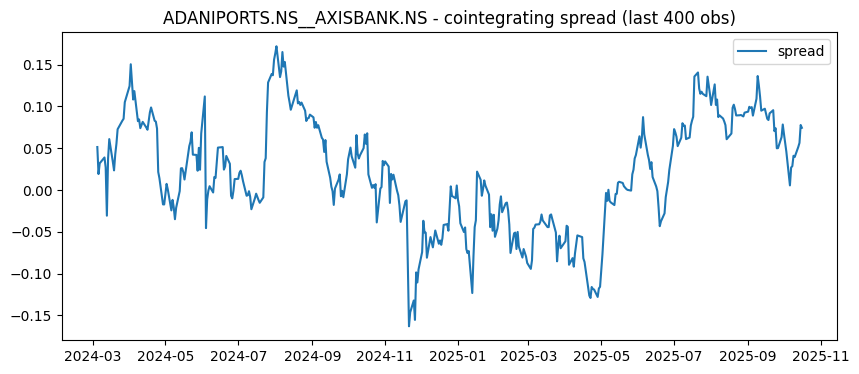

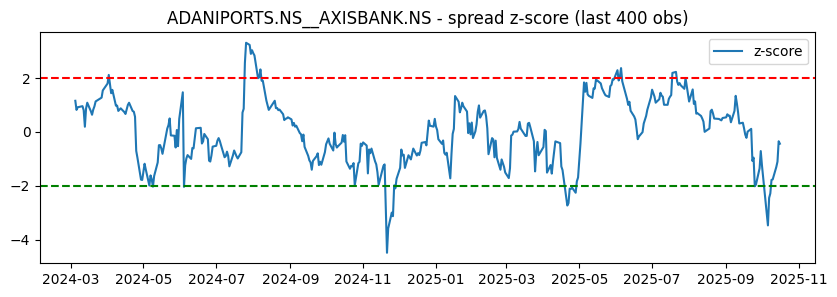

Forecast prices for ADANIPORTS.NS__AXISBANK.NS (first few rows):
Ticker      ADANIPORTS.NS_log  AXISBANK.NS_log
2025-10-17        1475.478823      1195.079844
2025-10-20        1474.931903      1195.042919
2025-10-21        1474.188344      1194.939175
2025-10-22        1473.460878      1194.839882
2025-10-23        1472.737247      1194.740941

=== Processing pair: ADANIPORTS.NS & BHARTIARTL.NS ===
Chosen lag for pair (BIC preferred): 1 (AIC=0, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 6.381, 95%cv = 15.494
 r ≤ 1: trace = 0.115, 95%cv = 3.841
Estimated cointegration rank r = 0
No cointegration found for pair ADANIPORTS.NS__BHARTIARTL.NS (r=0). Skipping VECM & forecast.

=== Processing pair: ADANIPORTS.NS & BPCL.NS ===
Chosen lag for pair (BIC preferred): 1 (AIC=0, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 15.242, 95%cv = 15.494
 r ≤ 1: trace = 0.999, 95%cv = 3.841
Estimated cointegration rank r = 0
No cointegrati

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Chosen lag for pair (BIC preferred): 1 (AIC=3, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 15.145, 95%cv = 15.494
 r ≤ 1: trace = 2.137, 95%cv = 3.841
Estimated cointegration rank r = 0
No cointegration found for pair AXISBANK.NS__BPCL.NS (r=0). Skipping VECM & forecast.

=== Processing pair: AXISBANK.NS & BRITANNIA.NS ===
Chosen lag for pair (BIC preferred): 1 (AIC=3, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 16.232, 95%cv = 15.494
 r ≤ 1: trace = 3.692, 95%cv = 3.841
Estimated cointegration rank r = 1
 Det. terms outside the coint. relation & lagged endog. parameters for equation AXISBANK.NS_log 
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
L1.AXISBANK.NS_log.AXISBANK     -0.0357      0.037     -0.965      0.335      -0.108       0.037
L1.BRITANNIA.NS_log.AXISBANK     

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


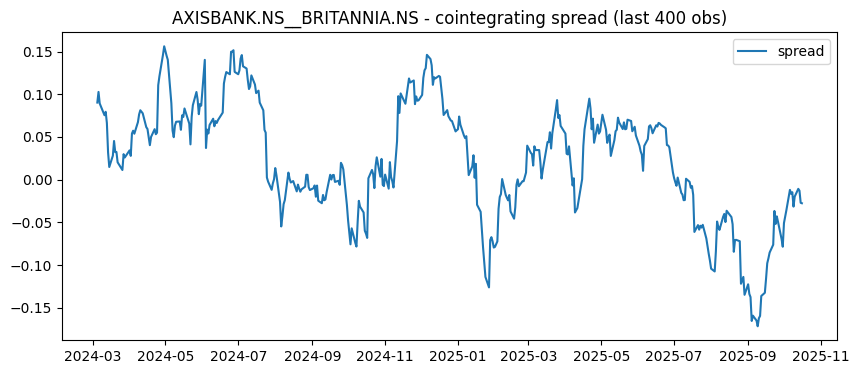

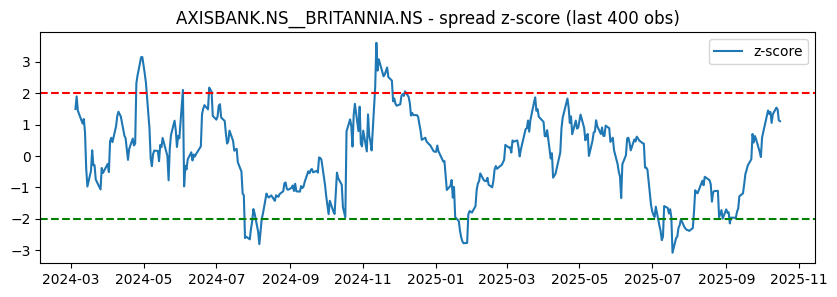

Forecast prices for AXISBANK.NS__BRITANNIA.NS (first few rows):
Ticker      AXISBANK.NS_log  BRITANNIA.NS_log
2025-10-17      1199.064935       6023.852434
2025-10-20      1199.492123       6020.309888
2025-10-21      1199.949721       6017.511784
2025-10-22      1200.403199       6014.825451
2025-10-23      1200.842590       6012.222952

=== Processing pair: BHARTIARTL.NS & BPCL.NS ===
Chosen lag for pair (BIC preferred): 1 (AIC=0, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 7.303, 95%cv = 15.494
 r ≤ 1: trace = 0.539, 95%cv = 3.841
Estimated cointegration rank r = 0
No cointegration found for pair BHARTIARTL.NS__BPCL.NS (r=0). Skipping VECM & forecast.

=== Processing pair: BHARTIARTL.NS & BRITANNIA.NS ===
Chosen lag for pair (BIC preferred): 1 (AIC=0, BIC=0)
Johansen trace stats and 95% critical values (r <= i):
 r ≤ 0: trace = 9.581, 95%cv = 15.494
 r ≤ 1: trace = 0.162, 95%cv = 3.841
Estimated cointegration rank r = 0
No cointegration found for pa

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [4]:
# ---------- USER PARAMETERS ----------


# any number of tickers

#tickers = ["ICICIBANK.NS", "HDFCBANK.NS", "AXISBANK.NS"]

tickers = [
    "ADANIPORTS.NS",
    "AXISBANK.NS",
    "BHARTIARTL.NS",
    "BPCL.NS",
    "BRITANNIA.NS",]

"""
tickers = ["CIPLA.NS",
    "COALINDIA.NS",
    "DIVISLAB.NS",
    "DRREDDY.NS",
    "EICHERMOT.NS",
    "GRASIM.NS",
    "HCLTECH.NS",
    "HDFCBANK.NS",
    "HDFCLIFE.NS",
    "HEROMOTOCO.NS",
    "HINDALCO.NS",
    "HINDUNILVR.NS",
    "ICICIBANK.NS",
    "ITC.NS",
    "INFY.NS",
    "JSWSTEEL.NS",
    "KOTAKBANK.NS",
    "LT.NS",
    "M&M.NS",
    "MARUTI.NS",
    "NESTLEIND.NS",
    "NTPC.NS",
    "ONGC.NS",
    "POWERGRID.NS",
    "RELIANCE.NS",
    "SBILIFE.NS",
    "SBIN.NS",
    "SUNPHARMA.NS",
    "TATACONSUM.NS",
    "TATAMOTORS.NS",
    "TATASTEEL.NS",
    "TCS.NS",
    "TECHM.NS",
    "TITAN.NS",
    "ULTRACEMCO.NS",
    "UPL.NS",
    "WIPRO.NS",
    "ADANIGREEN.NS",
    "DMART.NS"
]
"""
start_date = (datetime.today() - timedelta(days=3*365)).strftime("%Y-%m-%d")  # 3 years
end_date = datetime.today().strftime("%Y-%m-%d")
freq = "1d"   # daily
maxlags_to_check = 12  # for lag selection
forecast_horizon = 10   # days to forecast
rolling_window = 60     # spread z-score rolling window
deterministic = "n"     # VECM deterministic term: 'n','co','ci','lt'
output_dir = "vecm_pair_outputs"
os.makedirs(output_dir, exist_ok=True)
# -------------------------------------

def download_prices(tickers, start_date, end_date, freq="1d"):
    df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, interval=freq, progress=False)["Adj Close"]
    # ensure DataFrame shape even if single ticker
    if isinstance(df, pd.Series):
        df = df.to_frame(name=tickers[0])
    df = df.dropna()
    # ensure columns match tickers input order (yfinance sometimes reorders)
    df = df[tickers]
    return df

def select_lag_for_pair(log_pair, maxlags=12):
    """
    Select lag on differences using VAR lag selection (AIC/BIC).
    Returns chosen_lag (int), and a dict with aic/bic objects for recording.
    """
    diff = log_pair.diff().dropna()
    model = VAR(diff)
    sel = model.select_order(maxlags)
    aic = sel.aic
    bic = sel.bic
    # choose BIC if valid else AIC else 1
    chosen = None
    if not np.isnan(bic):
        chosen = int(bic)
    elif not np.isnan(aic):
        chosen = int(aic)
    else:
        chosen = 1
    chosen = max(1, chosen)
    return chosen, {"aic": aic, "bic": bic, "sel_obj": sel}

def run_johansen_for_pair(log_pair, k_ar_diff, det_order=0):
    """
    Runs Johansen on 2-series. Returns the full result object.
    """
    # coint_johansen expects ndarray (T x n)
    return coint_johansen(log_pair.values, det_order=det_order, k_ar_diff=k_ar_diff)

def fit_vecm_and_forecast(log_pair, chosen_lag, rank, forecast_horizon, deterministic="n"):
    """
    Fit VECM on log_pair (DataFrame with 2 columns), forecast steps and return:
    - vecm_res (result object)
    - forecast_prices_df (DataFrame, price levels)
    - forecast_log_df (DataFrame, log-forecasts)
    """
    vecm = VECM(log_pair, k_ar_diff=chosen_lag, coint_rank=rank, deterministic=deterministic)
    vecm_res = vecm.fit()
    # forecast returns array (steps x nseries) of log-level predictions
    fc_log = vecm_res.predict(steps=forecast_horizon)
    fc_index = pd.bdate_range(start=log_pair.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
    fc_log_df = pd.DataFrame(fc_log, index=fc_index, columns=log_pair.columns)
    fc_price_df = np.exp(fc_log_df)
    return vecm_res, fc_price_df, fc_log_df

def compute_spread_and_z(log_pair, beta_vec, rolling_window=60, min_periods=20):
    """
    Given a 2-column log_pair and cointegrating vector beta (array length 2),
    compute spread = beta' * log_prices and z-score with rolling window.
    """
    spread = log_pair.values.dot(beta_vec)
    spread_series = pd.Series(spread, index=log_pair.index, name="spread")
    ma = spread_series.rolling(window=rolling_window, min_periods=min_periods).mean()
    sd = spread_series.rolling(window=rolling_window, min_periods=min_periods).std()
    z = (spread_series - ma) / sd
    return spread_series, z

def process_pair(t1, t2, prices_all):
    pair_name = f"{t1}__{t2}"
    print(f"\n=== Processing pair: {t1} & {t2} ===")
    # extract prices for the pair and align
    pair_prices = prices_all[[t1, t2]].dropna()
    if len(pair_prices) < 60:
        print(f"Skipping {pair_name}: not enough observations ({len(pair_prices)} rows).")
        return None

    log_pair = np.log(pair_prices).rename(columns={t1: f"{t1}_log", t2: f"{t2}_log"})

    # 1) choose lag on differences
    chosen_lag, lag_info = select_lag_for_pair(log_pair, maxlags=maxlags_to_check)
    print(f"Chosen lag for pair (BIC preferred): {chosen_lag} (AIC={lag_info['aic']}, BIC={lag_info['bic']})")

    # 2) Johansen test (on the two log price series)
    try:
        jres = run_johansen_for_pair(log_pair, k_ar_diff=chosen_lag, det_order=0)
    except Exception as e:
        print(f"Johansen failed for {pair_name}: {e}")
        return None

    trace_stats = jres.lr1
    crit_vals = jres.cvt  # (r rows)
    print("Johansen trace stats and 95% critical values (r <= i):")
    for i, (tstat, cv) in enumerate(zip(trace_stats, crit_vals)):
        print(f" r ≤ {i}: trace = {tstat:.3f}, 95%cv = {cv[1]:.3f}")

    # determine rank at 95% level
    rank = 0
    for i, (tstat, cv) in enumerate(zip(trace_stats, crit_vals)):
        if tstat > cv[1]:
            rank = i + 1
        else:
            break
    print(f"Estimated cointegration rank r = {rank}")

    if rank < 1:
        print(f"No cointegration found for pair {pair_name} (r=0). Skipping VECM & forecast.")
        return {"pair": pair_name, "cointegrated": False, "rank": rank}

    # 3) Fit VECM and forecast
    try:
        vecm_res, fc_prices, fc_log = fit_vecm_and_forecast(log_pair, chosen_lag, rank, forecast_horizon, deterministic=deterministic)
    except Exception as e:
        print(f"VECM fit/forecast failed for {pair_name}: {e}")
        return {"pair": pair_name, "cointegrated": False, "rank": rank, "error": str(e)}

    # handle potential statsmodels summary IndexError when printing
    try:
        s = vecm_res.summary()
        print(s)
    except IndexError:
        print("Statsmodels summary() produced IndexError — continuing (model likely fitted).")

    # 4) Extract first cointegrating vector (beta) and compute spread & z
    beta = vecm_res.beta  # shape (nvars, r)
    # choose first beta column
    first_beta = beta[:, 0]
    spread_series, z_series = compute_spread_and_z(log_pair, first_beta, rolling_window=rolling_window)

    # Save results to CSV
    out_prefix = os.path.join(output_dir, pair_name)
    spread_df = pd.DataFrame({"spread": spread_series, "z": z_series})
    spread_df.to_csv(f"{out_prefix}_spread_z.csv")
    fc_prices.to_csv(f"{out_prefix}_forecast_prices.csv")
    # Save beta & alpha
    try:
        alpha_df = pd.DataFrame(vecm_res.alpha, index=log_pair.columns, columns=[f"alpha_{i+1}" for i in range(rank)])
        beta_df = pd.DataFrame(beta, index=log_pair.columns, columns=[f"beta_{i+1}" for i in range(rank)])
        alpha_df.to_csv(f"{out_prefix}_alpha.csv")
        beta_df.to_csv(f"{out_prefix}_beta.csv")
    except Exception:
        # in rare cases the shapes may not align — ignore saving if so
        pass

    # Plot spread and z (last 400 points)
    try:
        plt.figure(figsize=(10, 4))
        plt.plot(spread_series[-400:], label="spread")
        plt.title(f"{pair_name} - cointegrating spread (last 400 obs)")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 3))
        plt.plot(z_series[-400:], label="z-score")
        plt.axhline(2, color="r", linestyle="--")
        plt.axhline(-2, color="g", linestyle="--")
        plt.title(f"{pair_name} - spread z-score (last 400 obs)")
        plt.legend()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)

    print(f"Forecast prices for {pair_name} (first few rows):")
    print(fc_prices.head())

    return {
        "pair": pair_name,
        "cointegrated": True,
        "rank": rank,
        "beta": first_beta,
        "alpha": getattr(vecm_res, "alpha", None),
        "spread_csv": f"{out_prefix}_spread_z.csv",
        "forecast_csv": f"{out_prefix}_forecast_prices.csv"
    }

def cointF_all_pairs():
    print("Downloading all tickers price data...")
    prices_all = download_prices(tickers, start_date, end_date, freq)
    print(f"Downloaded {prices_all.shape[0]} rows x {prices_all.shape[1]} tickers.")
    results = []
    # iterate through all unordered pairs
    for t1, t2 in itertools.combinations(tickers, 2):
        res = process_pair(t1, t2, prices_all)
        if res is not None:
            results.append(res)
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(output_dir, "pairwise_vecm_summary.csv"), index=False)
    print("\nAll done. Summary written to:", os.path.join(output_dir, "pairwise_vecm_summary.csv"))
    return results_df

if __name__ == "__main__":
    summary = cointF_all_pairs()
    print("\nSummary:")
    print(summary)


## 🧩 Conclusion and Next Steps

In this project, we built a **portfolio-level VAR–VECM pairs trading simulator** that:

- Scans all possible pairs among chosen tickers,
- Detects cointegrated pairs using the **Johansen test**,
- Fits **VECM models** to cointegrated pairs to estimate equilibrium relationships,

---

**In summary**, the VAR–VECM approach provides a rigorous, system-level framework for discovering and exploiting long-run equilibrium relationships in financial markets.  
While it is statistically sound and powerful, success in live trading still depends on robust parameter estimation, adaptive recalibration, and prudent execution management.
